In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections.abc import Callable
from datetime import datetime

In [138]:
class NeuralNetwork:
	def __init__(
		self, 
		layers_structure: list[int], 
		parameters: np.ndarray | None = None, 
		activation: list[str] | str = 'sigmoid'
	) -> None:
		self.layers_structure: list[int] = layers_structure
		
		# number of layers, except the input layer
		self._L: int = len(layers_structure) - 1

		# calculation of the correct number of parameters 
		self._NUMBER_OF_PARAMS: int = 0
		for i in range(self._L):
			# number of weights
			self._NUMBER_OF_PARAMS += self.layers_structure[i] * self.layers_structure[i+1]

			# number of biases
			self._NUMBER_OF_PARAMS += self.layers_structure[i+1]
		
		
		self._weights_shapes: list[tuple[int]] = []
		self._biases_shapes: list[tuple[int]] = []
		# computing the appropriate shape of each weights matrix between layers
		for i in range(self._L):
			self._weights_shapes.append((self.layers_structure[i+1], self.layers_structure[i]))
			self._biases_shapes.append((self.layers_structure[i+1], 1))
		
		
		#? if the parameters is passed to __init__, then we'll set the weights and biases based on that
		if type(parameters) == np.ndarray:
			# check the shape before assignment
			if (s := max(parameters.shape)) != self._NUMBER_OF_PARAMS:
				raise ValueError(f'parameters should be of shape ({self._NUMBER_OF_PARAMS}, 1). Got {s} instead.')
			
			self.parameters: np.ndarray = parameters
			
			# setting both self.weights and self.biases, based on parameters
			self.parse_parameters()

		#? if parameters is not passed to __init__ we'll set them randomly
		else:
			self.weights: list[np.ndarray] = [np.random.randn(*shape) for shape in self._weights_shapes]
			self.biases: list[np.ndarray] = [np.random.randn(*shape) for shape in self._biases_shapes]

			# sets self.parameters, based on weights and biases
			self.recompute_parameters()

			
		#* type of activation
		# if only a str, apply it to all layers
		# if a list with size L(number_of_layers except input layer), apply individual activations
		if type(activation) == str:
			activation: list[str] = [activation for _ in range(self._L)]
		
		if len(activation) != self._L:
			raise ValueError(
				f'activation list should be of size [len(layers_structure)-1]={self._L}.\n Got {len(activation)} instead.'
			)
		
		self.activation: list[Callable] = []
		self.d_activation: list[Callable] = []
		
		for act in activation:
			match act:
				case 'sigmoid':
					self.activation.append(NeuralNetwork._sigmoid)
					self.d_activation.append(NeuralNetwork._d_sigmoid)
				case 'tanh':
					self.activation.append(NeuralNetwork._tanh)
					self.d_activation.append(NeuralNetwork._d_tanh)
				case 'relu':
					self.activation.append(NeuralNetwork._ReLU)
					self.d_activation.append(NeuralNetwork._d_ReLU)
				case 'no-activation':
					self.activation.append(lambda x: x)
					self.d_activation.append(lambda x: x)
				case _:
					raise ValueError('activations can be a member of ["sigmoid", "relu", "tanh", "no-activation"]')
		
		# initialize all the neurons with zero
		self.input_layer: np.ndarray = np.zeros((self.layers_structure[0], 1))

		# to initialize all z, and activations
		self.z_layers = [None for _ in range(self._L)]
		self.layers = [None for _ in range(self._L)]

		self.feed_forward()
		# input layer has no z or activation
		#self.z_layers: list[np.ndarray] = [np.zeros(shape=(num, 1)) for num in layers_structure[1:]]
		#self.layers: list[np.ndarray] = [af(z) for af, z in zip(self.activation, self.z_layers)]


	def load_input_layer(self, input_vector: np.ndarray) -> None:
		#* input_vector.shape = (self.layers_structure[0], 1)
		if input_vector.shape != (self.layers_structure[0], 1):
			raise ValueError(f'input should be of shape {(self.layers_structure[0], 1)}. got {input_vector.shape} instead')
		
		self.input_layer = input_vector
		

	def cost_of_single_sample(self, sample: np.ndarray, true_y: np.ndarray | np.integer | int, one_hot: bool = False) -> float:
		#* input_vector.shape = (self.layers_structure[0], 1)
		if sample.shape != (self.layers_structure[0], 1):
			raise ValueError(f'input should be of shape {(self.layers_structure[0], 1)}. got {sample.shape} instead')


		self.load_input_layer(input_vector=sample)
		self.feed_forward()
		
		#* basically this will come up in classification problems, which each neuron in the output layer
		# corresponds to one class and each class has a int value
		# for those cases we will create a one-hot true_y
		if one_hot:
			#* the passed true_y should only be an int
			if not isinstance(true_y, (int, np.integer)):
				raise ValueError(
					'when one_hot=True, the true_y passed should be int!'
				)
			# construct the output vector based on the label
			desired_output = np.zeros((self.layers_structure[-1], 1))
			desired_output[true_y] = 1
		else:
			if not isinstance(true_y, np.ndarray):
				raise ValueError(
					'when one_hot=False, the true_y passed should be numpy.ndarray!'
				)

			desired_output = true_y
		
		# compare the self.layers[-1] and the desired_output
		# using mean squared error	
		cost = np.sum((self.layers[-1] - desired_output)**2)
		return cost
	
	
	def cost_of_test_data(self, test_samples: np.ndarray, true_labels: np.ndarray, one_hot: bool = False) -> float:
		"""
			samples: is a np array which each col represents one sample			
			samples.shape = (self.layers_structure[0], m)
			if one_hot:
				true_labels.shape = (1, m)
			else:
				true_labels.shape = (m, self.layers_structure[-1], 1)	
		"""		
		
		MSE: float = 0
		M = len(test_samples.T)
		
		if one_hot:
			if true_labels.shape != (1, M):
				raise ValueError(
					f'true_labels.shape should be (1, {M}). Got {true_labels.shape} instead!'
				)
			true_labels = true_labels[0] 
			# now is a vector of ints
		else:
			if true_labels.shape != (M, self.layers_structure[-1], 1):
				raise ValueError(
					f'true_labels.shape should be {(M, self.layers_structure[-1], 1)}. Got {true_labels.shape} instead!'
				)
		for sample, label in zip(test_samples.T, true_labels):
			# if one_hot -> label: int
			# else       -> label.shape = (self.layers_structure[-1], 1)
			
			sample = sample.reshape((-1, 1))
			MSE += self.cost_of_single_sample(sample, label, one_hot=one_hot)

		
		MSE = (1 / M) * MSE
		return MSE


	def accuracy_score(self, test_samples: np.ndarray, true_labels: np.ndarray) -> float:
		#* test_samples.shape = (self.layer_structure[0], m)
		# true_labels.shape = (1, m)
	
		M: int = len(test_samples.T)		
		trues: int = 0

		for sample, label in zip(test_samples.T, true_labels[0]):
			sample = sample.reshape((-1, 1))
			result = self.predict(sample)
			
			if result == label: trues += 1
						
		return (trues / M)


	def predict_v(self, sample: np.ndarray) -> np.ndarray:
		#* sample.shape = (self.layers_structure[0], 1)
		if sample.shape != (self.layers_structure[0], 1):
			raise ValueError(f'{sample.shape} is a bad shape for input. should be {(self.layers_structure[0], 1)}.')

		self.load_input_layer(input_vector=sample)
		self.feed_forward()
		
		return self.layers[-1]

	
	def predict(self, sample: np.ndarray) -> int:
		output_vector = self.predict_v(sample).flatten()
		return np.argmax(output_vector)


	def _backprop_one_sample(self, sample: np.ndarray, label: np.ndarray | np.integer | int, one_hot: bool = False) -> tuple:
		"""
			This method holds all the math and calculus behind backpropagation
			it calculates the derivitive of the cost w.r.t all the weights and
			biases of the network, for only ONE training data
		"""
		
		self.load_input_layer(input_vector=sample)
		self.feed_forward()

		#* convert the label in int format into a one-hot vector
		if one_hot:
			if not isinstance(label, (np.integer, int)):
				raise ValueError(
					'when one_hot=True, label should be int!'
				)
			desired_output = np.zeros(self.layers[-1].shape)
			desired_output[label] = 1.0
		else:
			if (not isinstance(label, np.ndarray)) or (label.shape != (self.layers_structure[-1], 1)):
				raise ValueError(
					f'when one_hot=False, label should be np.ndarray of shape ({self.layers_structure[-1]}, 1)!'
				)
			desired_output = label

		#* d_cost_p_ol.shape = (self.layers_structure[-1], 1)
		#* derivative of mean squared error
		d_cost_p_ol = 2 * (self.layers[-1] - desired_output)

		#* d_activation(z_ol)
		#* times the gradient of the cost w.r.t activations of the output layer
		#* error_ol.shape =(self.layers_structure[-1], 1)
		error_ol = self.d_activation[-1](self.z_layers[-1]) *  d_cost_p_ol
		
		# error of all the other layers, except the last layer and the input layer
		#* this errors are gonna be in reverse order, so the first item will be the second to last layer's
		#* and the next will be the third from last layer's and so on ...
		hlayers_errors: list[np.ndarray] = []

		
		# loop through hidden layers in reverse order, from secnod to last layer, to the second layer
		# L-2 is because we should start at the last hidden layer
		e_count = 0
		for i in range(self._L - 2, -1, -1):
			#* the layer before the output layer
			if i == self._L - 2:
				e = self.d_activation[i](self.z_layers[i]) * (self.weights[i+1].T @ error_ol)
				hlayers_errors.append(e)
			else:
				#* remember errors[L-2-i] should be used, and it actually means the error of the next layer
				#* this is because it is in the reveresed order
				#e = self.d_activation[i](self.z_layers[i]) * (self.weights[i+1].T @ hlayers_errors[self.L-2-i])
				e = self.d_activation[i](self.z_layers[i]) * (self.weights[i+1].T @ hlayers_errors[e_count])
				e_count += 1
				hlayers_errors.append(e)

		#* now we can flip the errors for convenience
		hlayers_errors = hlayers_errors[::-1]
		
		# of length L
		d_cost_p_biases: list[np.ndarray] = []
		#* based on the equations of backprpoagation we know that d_cost_p_b of each layer
		#* is actually equal to the error of that layer.
		for error in hlayers_errors:
			d_cost_p_biases.append(error)
		d_cost_p_biases.append(error_ol)


		#* based on the equations of backpropagation
		#* the derivative of the cost wr to the weights of the layer l will be
		#* the matrix mult of error of layer l and activation of layer l-1 transposed
		d_cost_p_weights: list[np.ndarray] = []

		d_cost_p_weights.append(hlayers_errors[0] @ self.input_layer.T)
		for i in range(1, self._L - 1):
			d_cost_p_weights.append(error[i] @ self.layers[i-1].T)
		d_cost_p_weights.append(error_ol @ self.layers[-2].T)


		return (d_cost_p_weights, d_cost_p_biases)

	
	def backpropagation(self, x_train: np.ndarray, y_train: np.ndarray, one_hot: bool = False) -> tuple:
		"""
			This method will run the backprop_one_sample method for a dataset and 
			take the average of all the gradients of the weights and biases
		"""

		#* m training samples
		#* x_train.shape = (self.layers_structure[0], m)
		#* if one_hot -> y_train.shape = (1, m)
		#* else       -> y_train.shape = (m, self.layers_structure[-1], 1)
		M = len(x_train.T)
		if one_hot:
			if y_train.shape != (1, M):
				raise ValueError(
					f'true_labels.shape should be (1, {M}). Got {y_train.shape} instead!'
				)
			y_train = y_train[0] 
			# now is a vector of ints
		else:
			if y_train.shape != (M, self.layers_structure[-1], 1):
				raise ValueError(
					f'true_labels.shape should be {(M, self.layers_structure[-1], 1)}. Got {y_train.shape} instead!'
				)


		# average derivative of cost w.r.t weights
		dw: list[np.ndarray] = [np.zeros(shape) for shape in self._weights_shapes]
		
		# average derivative of cost w.r.t biases
		db: list[np.ndarray] = [np.zeros(shape) for shape in self._biases_shapes]

		for features, label in zip(x_train.T, y_train):
			#* features.shape = (self.layers_structure[0], 1)
			#* if one_hot -> label: int
			#* else       -> label.shape = (self.layers_structure[-1], 1)
			features = features.reshape((-1, 1))

			tdw, tdb = self._backprop_one_sample(sample=features, label=label, one_hot=one_hot)
			
			for i in range(self._L):
				dw[i] += tdw[i]
				db[i] += tdb[i]
			
		#* now each element in the dw and db contain the sum of the derivatives of 
		#* the samples inside the training data
		#* now they should be divided by the number of the train sample size, so dw and db, be an average
		
		for i in range(self._L):
			dw[i] /= M
			db[i] /= M

		#* now they contain the gradient of the provided dataset
		return (dw, db)
			

	def train(
			self, 
			x_train: np.ndarray, 
			y_train: np.ndarray,
			*,
			one_hot: bool = False,
			constant_lr: bool = False,
			learning_rate: float = 0.1,
			decay_rate: float = 0.1,
			number_of_epochs: int = 50,
			batch_size: int = 100
	) -> None:
		"""Trains the model with the labeled training data"""

		#* initialize the parameters randomly
		#* it is assumed that the parameters are initialized randomly
		
		#* m training samples
		#* x_train.shape = (self.layers_structure[0], m)
		#* if one_hot -> y_train.shape = (1, m)
		#* else       -> y_train.shape = (m, self.layers_structure[-1], 1)
		M = len(x_train.T)
		
		if one_hot:
			if y_train.shape != (1, M):
				raise ValueError(
					f'when one_hot=True, y_train.shape should be (1, {M})!'
				)
			
			y_train_new = np.array([])
			for label in y_train.flatten():
				# label is int
				# should create one hot array
				arr = np.zeros((self.layers_structure[-1], 1))
				arr[label] = 1
				y_train_new = np.append(y_train_new, arr)
			
			y_train = y_train_new.reshape((M, self.layers_structure[-1], 1))
			# now y_train is regular, each row is an output label vector
		else:
			if y_train.shape != (M, self.layers_structure[-1], 1):
				raise ValueError(
					f'when one_hot=False, y_train.shape should be {(M, self.layers_structure[-1], 1)}!'
				)
		
		#* first we'd better attach the x_train and y_train together
		#* then we can shuffle the training data
		
		# now the x_train.shape = (self.layers_structure[0], M)
		# now the y_train.shape = (M, self.layers_structure[-1], 1)
		# we have to attach x and y and then shuffle
		
		# x_train.T.shape = (M, self.layers_structure[0])
		train_data: list[tuple[np.ndarray, np.ndarray]] = list(zip(x_train.T, y_train))
		# len(train_data) = M
		
		np.random.shuffle(train_data)
		# now train_data is shuffled
		
		#* now that the data is shuffled properly
		#* we should divide the data into mini-batches	
		mini_batches: list[list[tuple[np.ndarray, np.ndarray]]] = [
			train_data[count:count+batch_size]
			for count in range(0, M, batch_size)
		]
		
		#* keep track of the accuracy scores, to plot later	
		scores: list[float] = []

		initial_lr: float = learning_rate
		for epoch in range(number_of_epochs):
			#* now each batch corresponds to one step at gradient descent
			for batch in mini_batches:
				#* batch -> list[tuple[np.ndarray, np.ndarray]] with len batch_size or less(for the last element, maybe)
				x_train_batch = np.array([])
				y_train_batch = np.array([])
				for data in batch:
					# data -> tuple[np.ndarray, np.ndarray]
					x_train_batch = np.append(x_train_batch, data[0])
					y_train_batch = np.append(y_train_batch, data[1])

				x_train_batch = x_train_batch.reshape((self.layers_structure[0], -1))
				# putting -1 instead of batch_size, because it might be less than batch_size

				y_train_batch = y_train_batch.reshape((-1, self.layers_structure[-1], 1))

				# now because y_train_batch holds the labels, and they should be int
				y_train_batch = y_train_batch.astype(np.int64)

				#* the backprop algorithm will run for each batch, one step downhill towards a local minima
				#* it also updates the self.layers[-1] (output layer)
				#* and consequently the cost, by running self.feed_forward in the background
				dw, db = self.backpropagation(x_train_batch, y_train_batch, one_hot=False)

				if constant_lr:
					lr = learning_rate
				else:
					lr = np.exp(-epoch * decay_rate) * initial_lr


				#* change each of the weights and biases accordingly
				self._update_parameters(dw, db, learning_rate=lr)
			
			#* parameters are updated now
			if one_hot: 
				score = self.accuracy_score(x_train, y_train)*100
				if epoch%20 == 0:	
					print(f'epoch {epoch+1}: accuracy = {score:.2f}%')
			else: 
				score = self.cost_of_test_data(x_train, y_train)
				if epoch%20 == 0:
					print(f'epoch {epoch+1}: cost = {score:.2f}')
			
			scores.append(score)

		self.plot_scores(list(range(1, number_of_epochs+1)), scores)


	def recompute_parameters(self) -> None:
		"""
			This method will recompute self.parameters from the current self.weights and self.biases
		"""
		self.parameters = np.array([])
		# first the weights
		for ws in self.weights:
			self.parameters = np.append(self.parameters, ws.flatten())
		# then the biases
		for bs in self.biases:
			self.parameters = np.append(self.parameters, bs.flatten())

		
		self.parameters = self.parameters.reshape((-1, 1))


	def init_weights_biases(self, weights: list[np.ndarray], biases: list[np.ndarray]) -> None:
		if len(weights) != self._L:
			raise ValueError(f'Weights list should contain {self._L} weights matrices!')
		
		for i, (ws, shape) in enumerate(zip(weights, self._weights_shapes)):
			if ws.shape != shape:
				raise ValueError(f'{ws.shape} is a wrong shape.(happened in weights[{i}]) should be {shape}.')

		for i, (bs, shape) in enumerate(zip(biases, self._biases_shapes)):
			if bs.shape != shape:
				raise ValueError(f'{bs.shape} is a wrong shape.(happened in biases[{i}]) should be {shape}.')

		self.weights: list[np.ndarray] = weights
		self.biases: list[np.ndarray] = biases
		self.recompute_parameters()


	def _update_parameters(self, dw, db, learning_rate) -> None:
		self.weights = [
			weights_matrix - (learning_rate * dw[i])
			for i, weights_matrix in enumerate(self.weights)
		]

		self.biases = [
			biases_vector - (learning_rate * db[i])
			for i, biases_vector in enumerate(self.biases)
		]

		#* now self.parameters, which basically is the flattened version of 
		#* all the weights and biases, should be updated as well
		self.recompute_parameters()


	def parse_parameters(self, parameters: np.ndarray | None = None) -> None:
		"""
			This method will parse self.parameters and set each parameter to the corresponding
			weights and biases
		"""
		# if the parameters is passed and is of correct shape, update the parameters
		if type(parameters) == np.ndarray:
			if parameters.shape != (self._NUMBER_OF_PARAMS, 1):
				raise ValueError(f'parameters should be of shape {(self._NUMBER_OF_PARAMS, 1)}.')
			
			self.parameters = parameters

		self.weights: list[np.ndarray] = []
		self.biases: list[np.ndarray] = []
		
		# grab the parameters for weights
		count: int = 0
		for shape in self._weights_shapes:
			total = shape[0] * shape[1]
			ws = self.parameters.T[0][count:count+total].reshape(shape)
			self.weights.append(ws)

			count += total
		
		# grab the parameters for biases
		for shape in self._biases_shapes:
			total = shape[0]
			bs = self.parameters.T[0][count:count+total].reshape(shape)
			self.biases.append(bs)

			count += total

		
	def plot_scores(self, epochs_range: list[int], scores: list[float]) -> None:
		fig = plt.figure()
		fig.tight_layout()
		plt.title('Accuracy Score per Epoch')
		plt.xlabel('Epoch')
		plt.ylabel('Accuracy Score')
		plt.xticks(epochs_range)
		plt.plot(epochs_range, scores)
		plt.show()
				
	@staticmethod
	def _sigmoid(z: np.ndarray) -> np.ndarray:
		return 1 / (1 + np.exp(-z))

	@staticmethod
	def _d_sigmoid(z: np.ndarray) -> np.ndarray:
		return np.exp(-z) / (np.pow((1 + np.exp(-z)), 2))


	@staticmethod
	def _ReLU(z: np.ndarray) -> np.ndarray:
		return np.maximum(0, z)
	
	
	@staticmethod
	def _d_ReLU(z: np.ndarray) -> np.ndarray:
		return (z > 0).astype(np.float64)
	

	@staticmethod
	def _tanh(z: np.ndarray) -> np.ndarray:
		return np.tanh(z)

	
	@staticmethod
	def _d_tanh(z: np.ndarray) -> np.ndarray:
		return 4 * np.exp(2 * z) / np.power(np.exp(2*z) + 1, 2)


	@staticmethod
	def _softmax(z: np.ndarray) -> np.ndarray:
		return np.exp(-z) / np.sum(np.exp(-z))


	def feed_forward(self) -> None:
		"""
			Will calculate all the values in all the layers 
			based on the weights and biases 
		"""

		# loop through each layer(except input layer) and calculate the z of the next layer
		# and the activation of the current
		for i in range(self._L):
			# connection between the input layer and the next layer
			if i == 0:
				self.z_layers[i] = (self.weights[0] @  self.input_layer) + self.biases[0]
			else:
				self.z_layers[i] = (self.weights[i] @ self.layers[i-1]) + self.biases[i]

			self.layers[i] = self.activation[i](self.z_layers[i])


		if self.layers[-1].shape != (self.layers_structure[-1], 1):
			raise ValueError(f'{self.layers[-1].shape} is a bad shape! Should be {(self.layers_structure[-1], 1)}')


	def print_network(self, hidden_layers = False) -> None:
		if hidden_layers:
			# all hidden layers, all layers except output layer
			for i, layer in enumerate(self.layers[:-1]):
				print(f'layer {i}: {layer}')

		print(f'Output layer:\n{self.layers[-1]}')


	def plot_network(self):
		layers = [
			l.reshape((-1,))
			for l in self.layers		
		]

		fig, ax = plt.subplots()
		
		# Determine the positions for the layers
		layer_sizes = [len(layer) for layer in layers]
		v_spacing = max(layer_sizes) + 1 + 3  # Vertical spacing between neurons
		h_spacing = 15  # Horizontal spacing between layers
		
		# Iterate over layers
		for i, layer in enumerate(layers):
			y_pos = np.linspace(v_spacing / 2, -v_spacing / 2, len(layer))
			x_pos = np.full_like(y_pos, i * h_spacing)
			
			# Plot neurons
			for j, neuron_value in enumerate(layer):
				circle = plt.Circle((x_pos[j], y_pos[j]), radius=0.4, facecolor=str(neuron_value), edgecolor='k')
				ax.add_artist(circle)
				# Optional: Add text to show the neuron value
				ax.text(x_pos[j]+1.5, y_pos[j], f'{neuron_value:.2f}', ha='center', va='center', color='black')

			# Draw connections (optional)
			if i > 0:
				prev_layer = layers[i - 1]
				prev_y_pos = np.linspace(v_spacing / 2, -v_spacing / 2, len(prev_layer))
				prev_x_pos = np.full_like(prev_y_pos, (i - 1) * h_spacing)
				for k in range(len(prev_layer)):
					for l in range(len(layer)):
						ax.plot([prev_x_pos[k], x_pos[l]], [prev_y_pos[k], y_pos[l]], 'k-', lw=0.04)

		ax.set_aspect('equal')
		ax.axis('off')
		plt.tight_layout()
		plt.show()

		
	def print_stat(self, x_test: np.ndarray, y_test: np.ndarray, one_hot: bool = False) -> None:
		# assumed that its used for classification problems
		# so y will be a vector of ints
		score = self.accuracy_score(x_test, y_test)
		cost = self.cost_of_test_data(x_test, y_test, one_hot=one_hot)

		print(f'Accuracy = {score * 100:.2f}%')
		print(f'Cost = {cost:.3f}')
	

	def	load_params_from_file(self, filename: str) -> None:
		with open(filename, 'r') as file:
			ps = [float(line.strip()) for line in file.readlines()]

		self.parse_parameters(np.array(ps).reshape((-1, 1)))


	def save_parameters_to_file(self, filename: str | None = None) -> None:
		if not filename:
			filename = f"parameters_{datetime.now().strftime('%y_%m_%d_%H_%M')}.txt"
		with open(filename, 'w') as file:
			for p in self.parameters.reshape((-1, )):
				file.write(f'{p}\n')


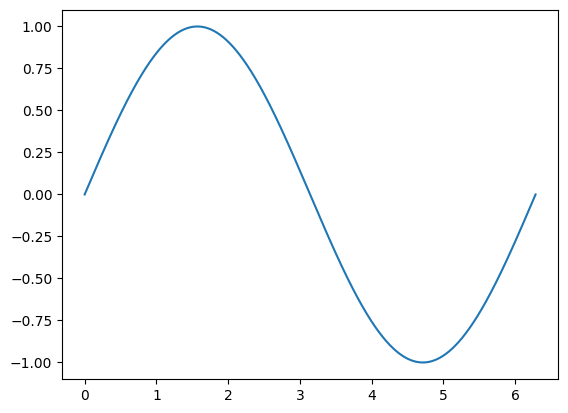

In [156]:
# the data
# lets train for sin wave!
M = 10000
x_train = np.linspace(0, 2*np.pi, M)
y_train = np.sin(x_train).reshape((-1, 1, 1))

plt.plot(x_train, y_train.flatten())

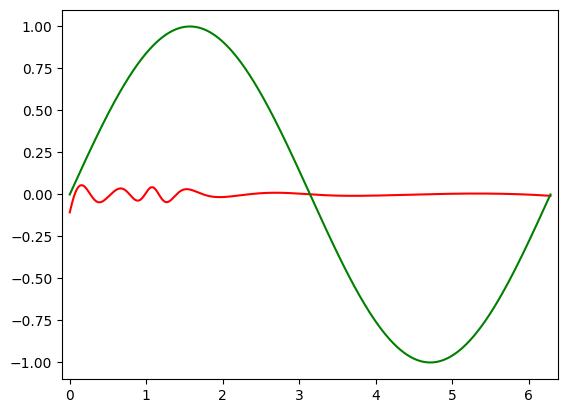

In [160]:
np.random.seed(42)
NN = NeuralNetwork(layers_structure=[1, 32, 32, 1], activation=['tanh', 'tanh', 'tanh'])
NN.train(x_train, y_train, number_of_epochs=1001, learning_rate=0.008, constant_lr=False, batch_size=150, decay_rate=0.01)

predicted = np.array([])
for x in x_train:
	predicted = np.append(predicted, NN.predict_v(x.reshape((-1, 1))))

plt.ylim([-1-0.1, 1+0.1])
plt.xlim([0-0.1, 2 * np.pi + 0.1])
plt.plot(x_train.flatten(), predicted.flatten(), 'r')
plt.plot(x_train.flatten(), y_train.flatten(), 'g')